In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


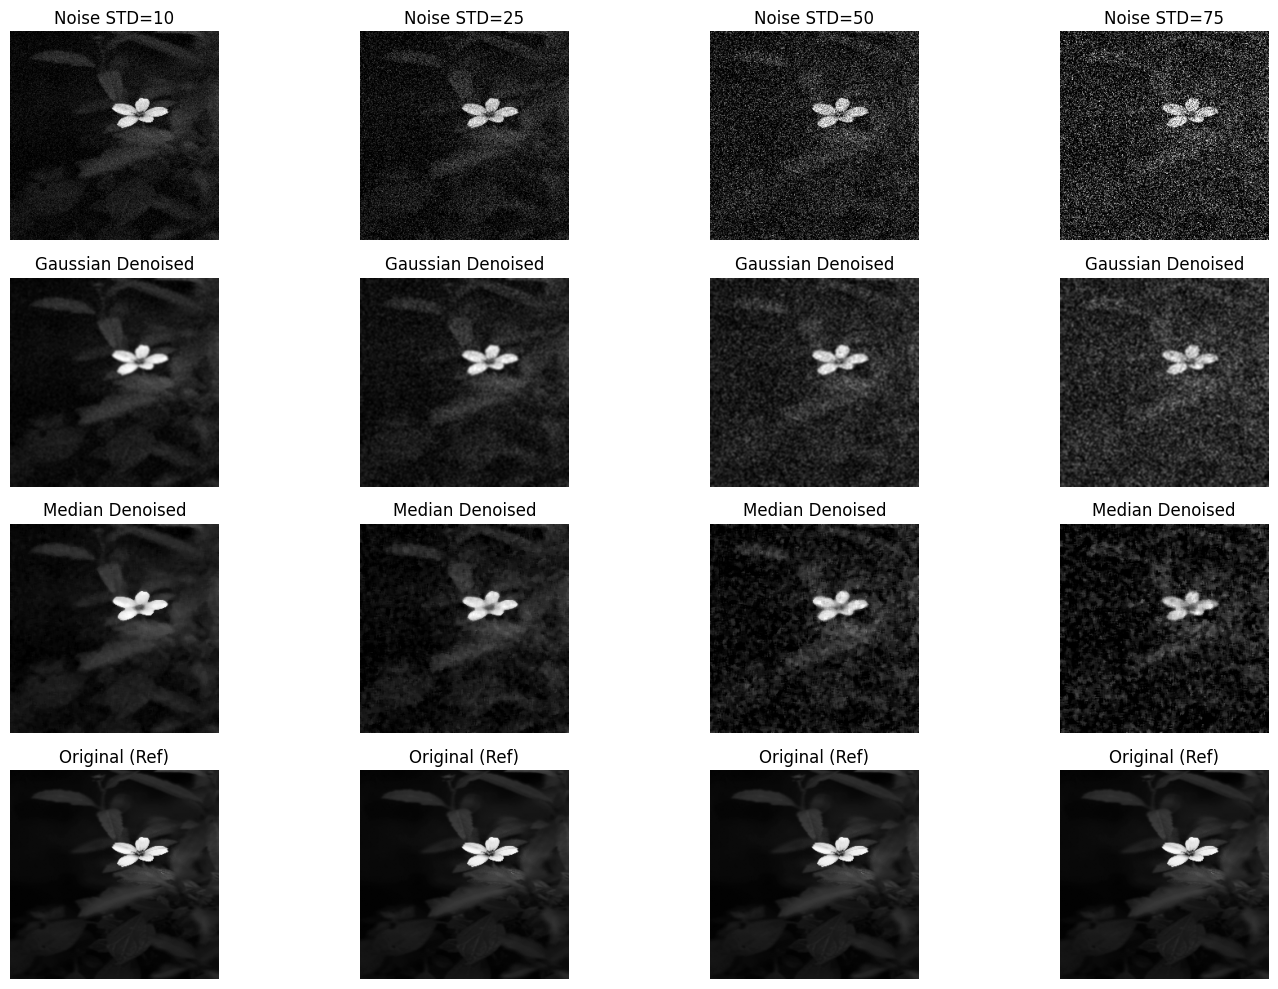

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image in grayscale
image = cv2.imread('/content/drive/MyDrive/FIP/flower.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))

# Function to add Gaussian noise correctly
def add_gaussian_noise(img, mean=0, std=25):
    noise = np.random.normal(mean, std, img.shape).astype(np.float32)
    noisy_img = img.astype(np.float32) + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    return noisy_img

# Gaussian denoising
def gaussian_denoise(img, ksize=(5, 5)):
    return cv2.GaussianBlur(img, ksize, 0)

# Median filtering
def median_denoise(img, ksize=5):
    return cv2.medianBlur(img, ksize)

# Apply noise at different levels
noise_levels = [10, 25, 50, 75]
noisy_images = [add_gaussian_noise(image, std=std) for std in noise_levels]

# Apply denoising filters
gaussian_denoised = [gaussian_denoise(img) for img in noisy_images]
median_denoised = [median_denoise(img) for img in noisy_images]

# Plot results
fig, axes = plt.subplots(4, len(noise_levels), figsize=(15, 10))

for i in range(len(noise_levels)):
    axes[0, i].imshow(noisy_images[i], cmap='gray')
    axes[0, i].set_title(f'Noise STD={noise_levels[i]}')
    axes[0, i].axis('off')

    axes[1, i].imshow(gaussian_denoised[i], cmap='gray')
    axes[1, i].set_title('Gaussian Denoised')
    axes[1, i].axis('off')

    axes[2, i].imshow(median_denoised[i], cmap='gray')
    axes[2, i].set_title('Median Denoised')
    axes[2, i].axis('off')

    axes[3, i].imshow(image, cmap='gray')
    axes[3, i].set_title('Original (Ref)')
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
image=image/255.0

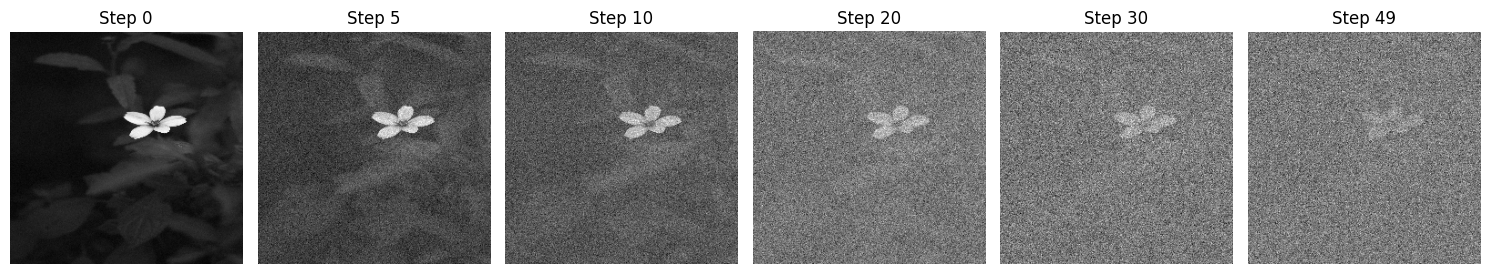

In [ ]:
image = image.astype(np.float32) / 255.0  # Normalize to [0,1]

# Define time steps and noise schedule
T = 50  # Total diffusion steps
beta_t = np.linspace(0.0001, 0.02, T)  # Linear schedule
alpha_t = 1 - beta_t
alpha_bar_t = np.cumprod(alpha_t)

# Forward diffusion process (adding noise)
noisy_images = []
for t in range(T):
    noise = np.random.normal(0, 1, image.shape)
    noisy_image = np.sqrt(alpha_bar_t[t]) * image + np.sqrt(1 - alpha_bar_t[t]) * noise
    noisy_images.append(noisy_image)

# Plot images at selected diffusion steps
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
time_steps = [0, 5, 10, 20, 30, T - 1]

for i, t in enumerate(time_steps):
    axes[i].imshow(noisy_images[t], cmap='gray')
    axes[i].set_title(f"Step {t}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


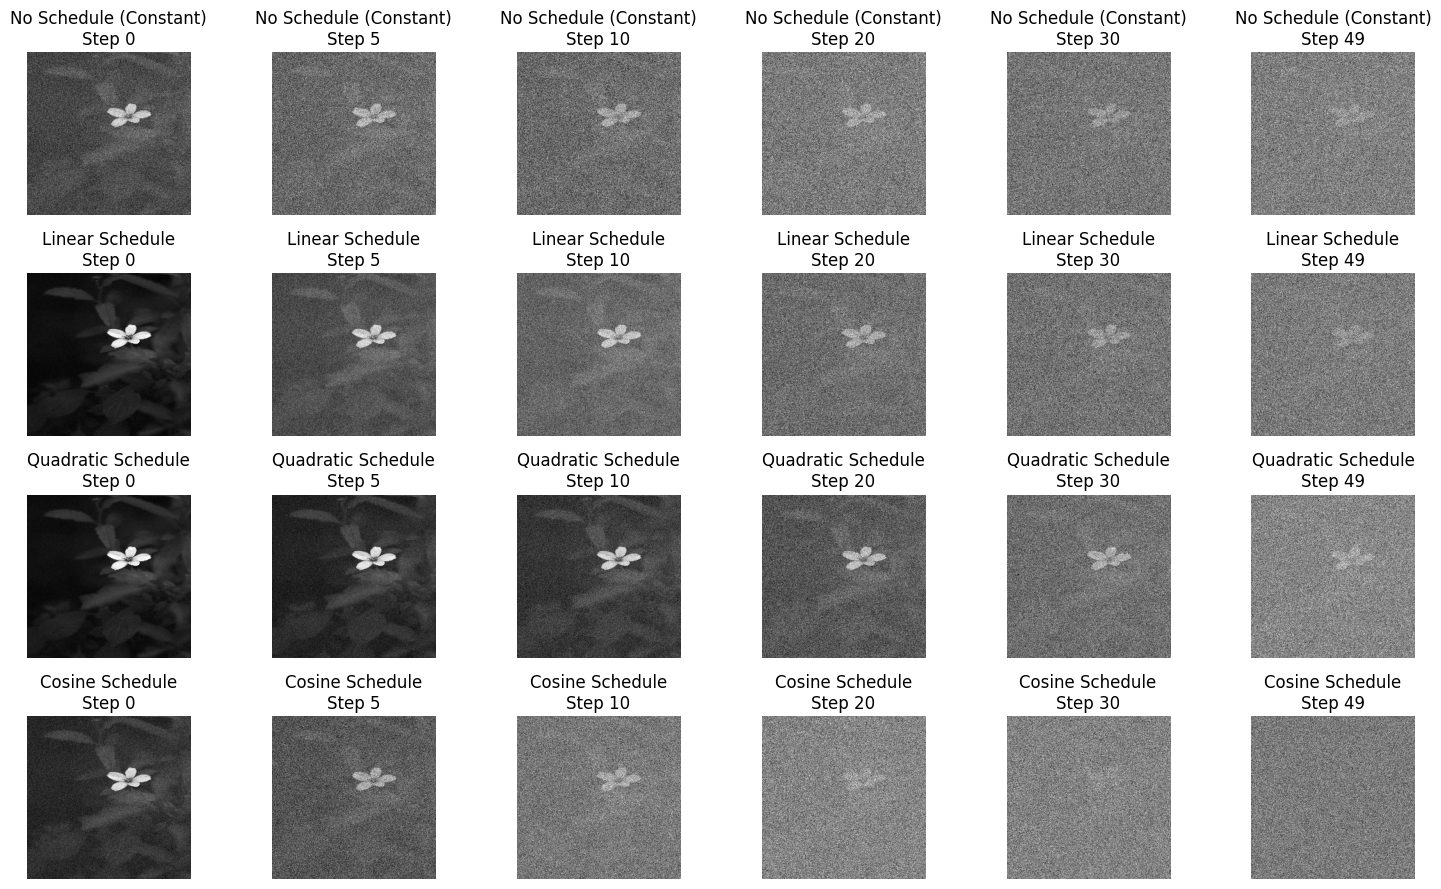

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load and normalize image
image = cv2.imread('/content/drive/MyDrive/FIP/flower.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))
image = image.astype(np.float32) / 255.0  # Normalize

# Total diffusion steps
T = 50

# --- Diffusion Schedules ---
def linear_schedule(T, beta_min=0.0001, beta_max=0.02):
    return np.linspace(beta_min, beta_max, T)

def quadratic_schedule(T, beta_min=0.0001, beta_max=0.02):
    return (np.linspace(0, 1, T) ** 2) * (beta_max - beta_min) + beta_min

def cosine_schedule(T, s=0.008):
    steps = np.arange(T + 1, dtype=np.float64)
    f = np.cos(((steps / T) + s) / (1 + s) * np.pi / 2) ** 2
    alpha_bar = f / f[0]
    beta = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return np.clip(beta, 0.0001, 0.999)

# --- Forward diffusion ---
def forward_diffusion(beta_t):
    alpha_t = 1 - beta_t
    alpha_bar_t = np.cumprod(alpha_t)

    noisy_images = []
    for t in range(T):
        noise = np.random.normal(0, 1, image.shape)
        noisy_img = np.sqrt(alpha_bar_t[t]) * image + np.sqrt(1 - alpha_bar_t[t]) * noise
        noisy_images.append(noisy_img)
    return noisy_images

# Define schedules
schedules = {
    "No Schedule (Constant)": np.ones(T) * 0.01,
    "Linear Schedule": linear_schedule(T),
    "Quadratic Schedule": quadratic_schedule(T),
    "Cosine Schedule": cosine_schedule(T)
}

# Plot diffusion results
time_steps = [0, 5, 10, 20, 30, T - 1]
fig, axes = plt.subplots(len(schedules), len(time_steps), figsize=(15, 9))

for row_idx, (name, beta_t) in enumerate(schedules.items()):
    noisy_imgs = forward_diffusion(beta_t)
    for col_idx, t in enumerate(time_steps):
        axes[row_idx, col_idx].imshow(noisy_imgs[t], cmap='gray')
        axes[row_idx, col_idx].set_title(f"{name}\nStep {t}")
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()
